In [1]:
'''
This notebook implements a batch run for OFAT analysis
Packages
'''
from model import *
import csv
from mesa.batchrunner import BatchRunner
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from joblib import Parallel, delayed, cpu_count

In [2]:
'''
Initial Conditions as given in notebook
'''
initial_houses = 20
initial_households = 30
rental_cost = 1000
savings_lower = 0
savings_upper = 50_000
price_lower = 10_000
price_upper = 100_000
columns = ('Variable', 'Parameter', 'Gini')

'''
This defines model run
'''
samples = 10
max_steps = 2
ofat_size = 5

In [3]:
'''
Defaults
'''
height = 20
width = 20
initial_houses = 100
initial_households = 150
savings_lower = 0
savings_upper = 0
price_lower = 100_000
price_upper = 1_000_000
payoff_perc_freehold = 0.0025
inflation = 0.02
house_price = 400_000
chi_parameter = 6.5
maximum_age = 100
minimum_age = 20
age_utility_scaling = 0.01
maximum_moving_age = 65
bank_income_multiplire = 8
fraction_good_houses = 0.05
price_shock_range = 6

In [4]:
begintime = time.time()

model = HousingMarket(initial_houses = 1000, initial_households = 1500)
model.run_model(1000)

print(time.time()-begintime)

192.65049266815186


In [17]:
model = HousingMarket()
model.run_model(1)
data_model = model.datacollector.get_model_vars_dataframe()
data_agent = model.datacollector.get_agent_vars_dataframe()

<AxesSubplot:xlabel='Age', ylabel='Count'>

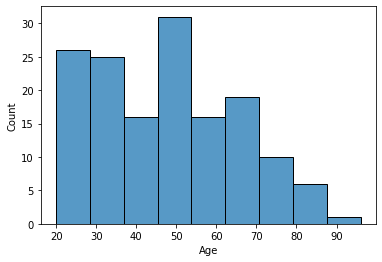

In [21]:
sns.histplot(data_agent['Age'])

<AxesSubplot:xlabel='Price', ylabel='Count'>

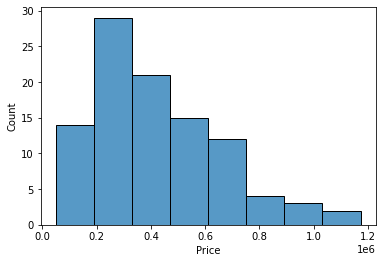

In [24]:
sns.histplot(data_agent['Price'])

<AxesSubplot:xlabel='Income', ylabel='Count'>

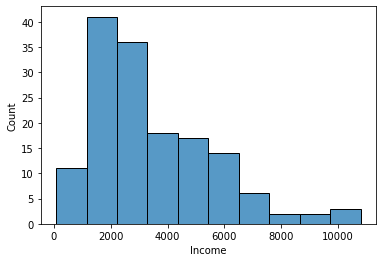

In [23]:
sns.histplot(data_agent['Income'])

In [13]:
with_policy = []

for i in range(30):

    model_s = HousingMarket(s_policy = True)
    model_s.run_model(1000)
    data = model_s.datacollector.get_model_vars_dataframe()
    with_policy.append(data['Gini'].iloc[-1])

KeyboardInterrupt: 

In [7]:
without_policy = []

for i in range(30):

    model = HousingMarket()
    model.run_model(1000)
    data = model.datacollector.get_model_vars_dataframe()
    without_policy.append(data['Gini'].iloc[-1])

(array([ 1.,  2.,  2., 10., 10.,  3.,  0.,  1.,  0.,  1.]),
 array([0.53948877, 0.55949489, 0.57950101, 0.59950713, 0.61951325,
        0.63951937, 0.65952549, 0.67953161, 0.69953772, 0.71954384,
        0.73954996]),
 <BarContainer object of 10 artists>)

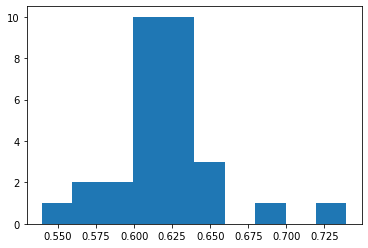

In [18]:
plt.hist(with_policy)

In [2]:
with_policy = [0.6213261645117449,
 0.6050512540468121,
 0.5706968280275854,
 0.6024173642934831,
 0.6096591195347608,
 0.6237800993743399,
 0.5999838868623774,
 0.5943187035599172,
 0.6266463163815885,
 0.6047192434386657,
 0.6310901285260624,
 0.7395499634397176,
 0.6808916368226712,
 0.5637972715899074,
 0.6117462314390414,
 0.6331443496084412,
 0.638656089477393,
 0.64747684719716,
 0.6399291102883214,
 0.6144390629195217,
 0.6051422716194456,
 0.6313681487803472,
 0.6303590524488282,
 0.5394887706002136,
 0.5803518400634279,
 0.6207974140627859,
 0.6291077167713206,
 0.6060806446244085,
 0.6134209167701576,
 0.6529005395129214]

In [1]:
without_policy = [0.6756987302347371,
 0.7107563179903934,
 0.7102380274583286,
 0.7045772052534821,
 0.6670904625160743,
 0.6966476826678603,
 0.7292923357913335,
 0.6306279772315005,
 0.7472405774336842,
 0.7035999961292325,
 0.674806910355441,
 0.6708145756701633,
 0.6882960132496131,
 0.6848473708944409,
 0.6928685153733973,
 0.7528871782047721,
 0.715898105870421,
 0.7175374090258434,
 0.7265511989777099,
 0.7340818481274871,
 0.729434697750979,
 0.6956311345058286,
 0.670007115156117,
 0.6846504979011825,
 0.7683271518099415,
 0.6845257838269473,
 0.6877348162645579,
 0.6733994458776674,
 0.677893910701769,
 0.6982151836836463]

In [5]:
np.mean(without_policy)

0.7001392725311518

In [6]:
np.std(without_policy)

0.029009939804112105

In [8]:
np.mean(with_policy)

0.6189445662197789

In [7]:
np.std(with_policy)

0.03528879284428119

In [12]:
# T-test
scipy.stats.ttest_ind(without_policy, with_policy)

Ttest_indResult(statistic=9.57146560781293, pvalue=1.5335355475390579e-13)

In [4]:
def collect_samples(samples, columns, parameter, values):
    df_experiment = pd.DataFrame(columns=columns)
    parameter_name = parameter
    
    for k in range(int(samples)):
        '''
        Repeat trial with certain parameter k times to apply clt
        '''            
        model = HousingMarket(parameter := values)
        model.run_model(max_steps)
        data = model.datacollector.get_model_vars_dataframe()
        dic = {'Variable': parameter_name, 'Parameter': parameter, 'Gini': data['Gini'].iloc[-1]}
        df_experiment = pd.concat([df_experiment, pd.DataFrame(pd.Series(dic)).T])
    return df_experiment

In [5]:
def run_batch_parallel(problem, i, ofat_size, samples, columns):
    parameter = problem['names'][i]
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    #df_experiment = pd.DataFrame(columns = columns)
    results = Parallel(n_jobs = cpu_count())(delayed(collect_samples)(samples, columns, parameter, int(value))
                       for value in variable_values)
    final = pd.concat(results)
    return final

In [6]:
def run_batch_parallel_plotter(result, i):
    '''
    This plots the result from running a batch runneri in parallel
    '''
    
    fig = plt.plot( figsize = (20,40))
    y = []
    err = []
    x = np.linspace(*problem['bounds'][i], ofat_size)

    for j in range(len(x)):
        series = result['Gini'][int(j*samples):int((j+1)*samples)]
        y.append(series.mean())
        err.append(1.96 * (series.std()/np.sqrt(samples)))

    plt.plot(x, y , c='k')
    plt.fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err)) 
    plt.ylabel("Gini")
    plt.xlabel(problem['names'][i])
    plt.show()
    

In [2]:
'''
This defines the bounds of for the ofat analysis
'''
problem = {
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 
              'payoff_perc_freehold', 'inflation', 'chi_parameter', 'back_income_multiplier'],
    'bounds': [[1, 40_000], [1, 100_000], [10_000, 90_000], [11_000, 100_000],
              [0.001,0.0025],[0.01,0.03],[5,7.5],[6,9]]    
}

columns = ('Variable', 'Parameter', 'Gini')

'''
This defines model run
'''
samples = 5
max_steps = 1000
ofat_size = 3

In [8]:
# Inflation
max_steps = 1000
results_0 = run_batch_parallel(problem, 4, ofat_size, samples, columns)

ValueError: empty range for randrange() (0, 0, 0)

In [9]:
max_steps = 1000
results_0 = run_batch_parallel(problem, 5, ofat_size, samples, columns)

ValueError: empty range for randrange()

Experiment Start now at Thu Jan 27 19:56:13 2022


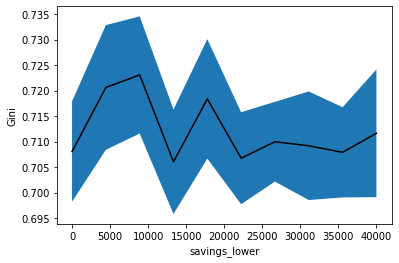

Experiment Start end at Thu Jan 27 20:04:45 2022
Experiment length in seconds 512.2256145477295


In [8]:
begin = time.time()
print(f'Experiment Start now at {time.ctime(int(time.time()))}')
results_0 = run_batch_parallel(problem, 0, ofat_size, samples, columns)
run_batch_parallel_plotter(results_0, 0)
print(f'Experiment Start end at {time.ctime(int(time.time()))}')
print(f'Experiment length in seconds {time.time()-begin}')

In [9]:
print(f'Experiment Start now at {time.ctime(int(time.time()))}\n')
results_1 = run_batch_parallel(problem, 1, ofat_size, samples, columns)
run_batch_parallel_plotter(results_1, 1)

Experiment Start now at Fri Jan 28 12:20:17 2022



ValueError: empty range for randrange() (1, 1, 0)

Experiment Start now at Thu Jan 27 20:11:36 2022



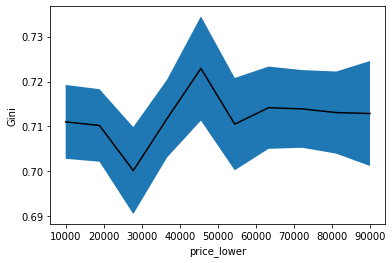

In [10]:
print(f'Experiment Start now at {time.ctime(int(time.time()))}\n')
results_2 = run_batch_parallel(problem, 2, ofat_size, samples, columns)
run_batch_parallel_plotter(results_2, 2)

Experiment Start now at Thu Jan 27 20:18:31 2022



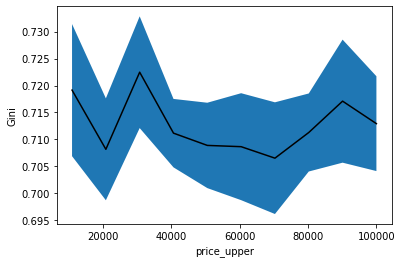

In [11]:
print(f'Experiment Start now at {time.ctime(int(time.time()))}\n')
results_3 = run_batch_parallel(problem, 3, ofat_size, samples, columns)
run_batch_parallel_plotter(results_3, 3)

Experiment Start now at Thu Jan 27 20:25:37 2022



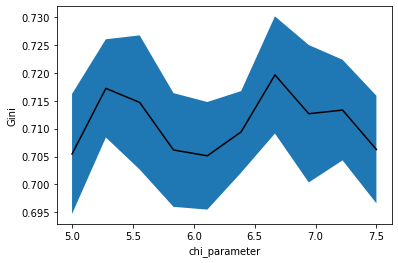

In [12]:
print(f'Experiment Start now at {time.ctime(int(time.time()))}\n')
results_6 = run_batch_parallel(problem, 6, ofat_size, samples, columns)
run_batch_parallel_plotter(results_6, 6)

Experiment Start now at Thu Jan 27 20:31:26 2022



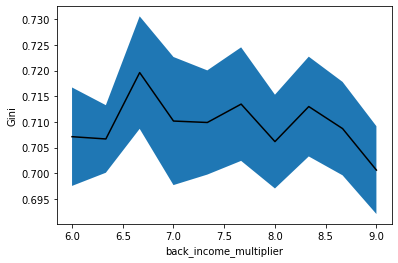

In [13]:
print(f'Experiment Start now at {time.ctime(int(time.time()))}\n')
results_7 = run_batch_parallel(problem, 7, ofat_size, samples, columns)
run_batch_parallel_plotter(results_7, 7)

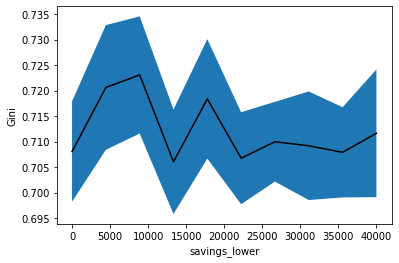

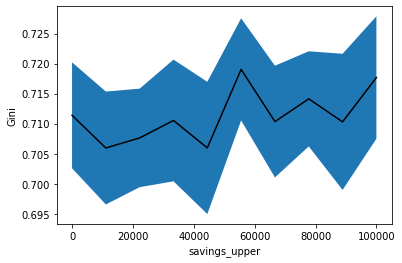

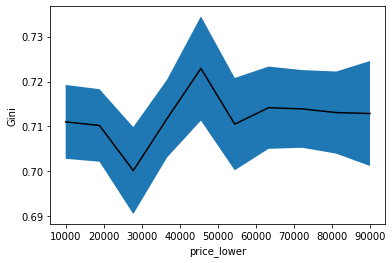

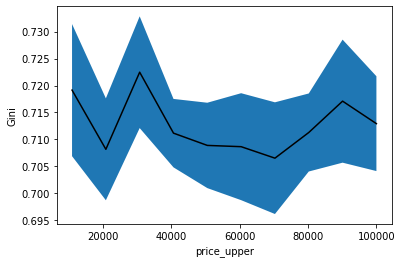

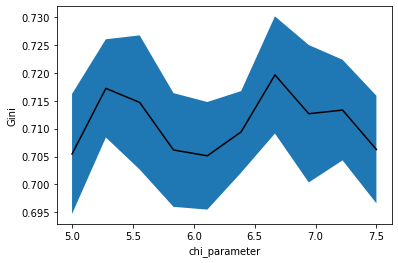

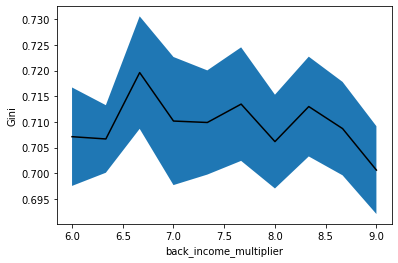

In [39]:
plot0 = run_batch_parallel_plotter(results_0, 0)
plot1 = run_batch_parallel_plotter(results_1, 1)
plot2 = run_batch_parallel_plotter(results_2, 2)
plot3 = run_batch_parallel_plotter(results_3, 3)
plot6 = run_batch_parallel_plotter(results_6, 6)
plot7 = run_batch_parallel_plotter(results_7, 7)